In [25]:
import pandas as pd
import numpy as np
import psycopg2
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 15]

In [44]:
host = "localhost"
nomeBanco = "grupo_extensão"
usuario = "csk"
senha = "csk123"
porta = 5432

def criarBD(hostName, dbName, userName, pw, port):
    try:
        conn = psycopg2.connect(
            host = hostName,
            dbname = dbName,
            user = userName,
            password = pw,
            port = port
        )
    except Exception as err:
        print("Houve um erro!")
        print(err)
    
    return conn

conn = criarBD( host, nomeBanco, usuario, senha, porta )

cur = conn.cursor()

In [45]:
df_completo = pd.read_csv("covid19_casos_brasil.csv")
df_completo.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0,0,3,city,SP,0,0


In [49]:
cur.execute("CREATE TABLE IF NOT EXISTS cidade (id serial PRIMARY KEY, city_ibge_code integer, city varchar, state varchar);")

In [50]:
conn.commit()

In [51]:
cur.execute("CREATE TABLE IF NOT EXISTS casos (id serial PRIMARY KEY, city_ibge_code integer, date last_available_confirmed integer, last_available_deaths integer, new_confirmed integer, new_deaths integer);")
conn.commit()

In [52]:
colsCidade = ['city_ibge_code', 'city', 'state']
filtro_cidades = (df_completo['city'] == 'Joinville') | (df_completo['city'] == 'Francisco Beltrão') | (df_completo['city'] == 'Dois Vizinhos') | (df_completo['city'] == 'Pato Branco') | (df_completo['city'] == 'Florianópolis')
df_completo_cidade = df_completo[filtro_cidades][colsCidade]
df_cidade = df_completo_cidade.tail()
df_cidade

,city_ibge_code,city,state
351707,4107207.0,Dois Vizinhos,PR
351729,4108403.0,Francisco Beltrão,PR
351860,4118501.0,Pato Branco,PR
352842,4205407.0,Florianópolis,SC
352892,4209102.0,Joinville,SC


In [53]:
for index, row in df_cidade.iterrows():
    cur.execute("""
        INSERT INTO cidade (city_ibge_code, city, state)
        VALUES (%(a)s, %(b)s, %(c)s);
        """,{'a': row['city_ibge_code'],
             'b': row['city'],
             'c': row['state']
            })
conn.commit()

In [55]:
colsCasos = ['city_ibge_code', 'last_available_confirmed', 'last_available_deaths', 'new_confirmed', 'new_deaths']
df_completo_casos = df_completo[filtro_cidades][colsCasos]
df_cidade = df_completo_casos
df_cidade

,city_ibge_code,last_available_confirmed,last_available_deaths,new_confirmed,new_deaths
124,4205407.0,2,0,2,0
161,4205407.0,2,0,0,0
162,4209102.0,1,0,1,0
204,4205407.0,2,0,0,0
205,4209102.0,1,0,0,0
...,...,...,...,...,...
351707,4107207.0,17,0,0,0
351729,4108403.0,178,4,0,0
351860,4118501.0,206,1,0,0
352842,4205407.0,2064,26,23,0


In [59]:
for index, row in df_cidade.iterrows():
    cur.execute("""
        INSERT INTO casos (city_ibge_code, last_available_confirmed, last_available_deaths, new_confirmed, new_deaths)
        VALUES (%(a)s, %(b)s, %(c)s, %(d)s, %(e)s);
        """,{'a': row['city_ibge_code'],
             'b': row['last_available_confirmed'],
             'c': row['last_available_deaths'],
             'd': row['new_confirmed'],
             'e': row['new_deaths']
            })
conn.commit()

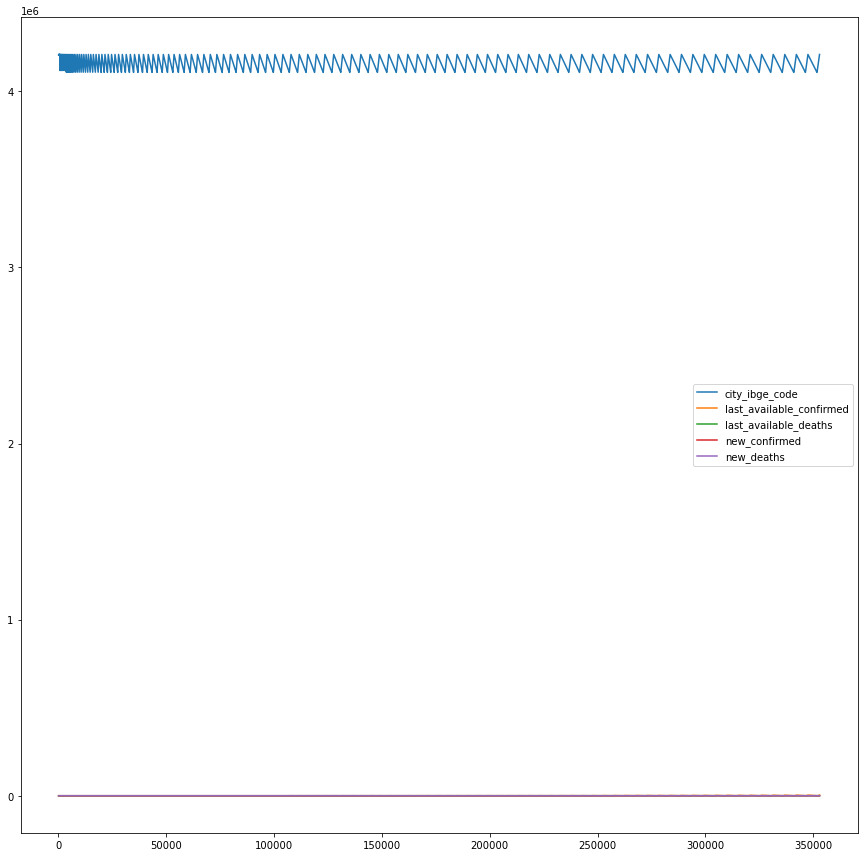